# Manage Your Machine Learning Models With Natural Language

In this notebook, we will show how to create a simple model management system using natural language processing. We will use the MLflow Tools Agent, which uses `mlflow` library to create and manage Machine Learning modeling projects, experiments, and runs. You will be able to interact with the agent using natural language commands.

The agent will be able to:
- Create a new project
- Create a new experiment
- Search runs
- Store and retrieve models
- Make predictions

### Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)

## MLflow Machine Learning Manager Agent

In this notebook, we will use the MLflow Machine Learning Manager Agent to manage our machine learning models. The MLflow Machine Learning Manager Agent is a powerful tool that allows you to manage your machine learning models with natural language.

## Pre-requisites

Before completing this tutorial, you should have the following pre-requisites:

- Create a H2O Model using the H2OMLAgent ([See this tutorial](/examples/ml_agents/h2o_machine_learning_agent.ipynb))
- Have `mlflow` installed. If not, you can install it using `pip install mlflow`

## What is MLflow?

MLflow is an open-source platform to manage the end-to-end machine learning lifecycle. MLflow streamlines machine learning development, including tracking experiments, packaging code into reproducible runs, and sharing and deploying models. 

MLflow offers a set of lightweight APIs that can be used with any existing machine learning application or library (H2O, Scikit Learn, TensorFlow, PyTorch, XGBoost, etc), wherever you currently run ML code (e.g., in notebooks, standalone applications, or as part of a data pipeline).

We'll use the MLflow API to manage our H2O model.

Make sure to install the `mlflow` package by running `!pip install mlflow` in your notebook.

Please complete this [H2O ML Agent tutorial](/examples/ml_agents/h2o_machine_learning_agent.ipynb) first before proceeding with this tutorial.

### Load Libraries

In [1]:

from langchain_openai import ChatOpenAI
import pandas as pd
import h2o 
import mlflow
import os
import yaml

from ai_data_science_team.ml_agents import MLflowToolsAgent

### Load The Customer Churn Dataset

The Customer Churn dataset contains data on customers who have left the company. The dataset contains 21 columns and 7,043 rows. The target variable is `Churn` which is a binary variable that indicates whether the customer has left the company or not.

In [2]:
df = pd.read_csv("data/churn_data.csv")
df

,customerID,gender,SeniorCitizen,Partner,Dependents,tenure,PhoneService,MultipleLines,InternetService,OnlineSecurity,...,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,Contract,PaperlessBilling,PaymentMethod,MonthlyCharges,TotalCharges,Churn
0,7590-VHVEG,Female,0,Yes,No,1,No,No phone service,DSL,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.85,29.85,No
1,5575-GNVDE,Male,0,No,No,34,Yes,No,DSL,Yes,...,Yes,No,No,No,One year,No,Mailed check,56.95,1889.5,No
2,3668-QPYBK,Male,0,No,No,2,Yes,No,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Mailed check,53.85,108.15,Yes
3,7795-CFOCW,Male,0,No,No,45,No,No phone service,DSL,Yes,...,Yes,Yes,No,No,One year,No,Bank transfer (automatic),42.30,1840.75,No
4,9237-HQITU,Female,0,No,No,2,Yes,No,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Electronic check,70.70,151.65,Yes
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
7038,6840-RESVB,Male,0,Yes,Yes,24,Yes,Yes,DSL,Yes,...,Yes,Yes,Yes,Yes,One year,Yes,Mailed check,84.80,1990.5,No
7039,2234-XADUH,Female,0,Yes,Yes,72,Yes,Yes,Fiber optic,No,...,Yes,No,Yes,Yes,One year,Yes,Credit card (automatic),103.20,7362.9,No
7040,4801-JZAZL,Female,0,Yes,Yes,11,No,No phone service,DSL,Yes,...,No,No,No,No,Month-to-month,Yes,Electronic check,29.60,346.45,No
7041,8361-LTMKD,Male,1,Yes,No,4,Yes,Yes,Fiber optic,No,...,No,No,No,No,Month-to-month,Yes,Mailed check,74.40,306.6,Yes


### LLM Setup

Run the code to set up your OpenAI API Key and set up key inputs for the LLM model creation and H2O AutoML model creation.

In [3]:
os.environ['OPENAI_API_KEY'] = "YOUR_OPENAI_API_KEY"
os.environ["OPENAI_API_KEY"] = yaml.safe_load(open('../credentials.yml'))['openai']

# Define constants for model, logging, and paths
MODEL    = "gpt-4o-mini"

# Initialize the language model
llm = ChatOpenAI(model=MODEL)
llm

ChatOpenAI(profile={'max_input_tokens': 128000, 'max_output_tokens': 16384, 'image_inputs': True, 'audio_inputs': False, 'video_inputs': False, 'image_outputs': False, 'audio_outputs': False, 'video_outputs': False, 'reasoning_output': False, 'tool_calling': True, 'structured_output': True, 'image_url_inputs': True, 'pdf_inputs': True, 'pdf_tool_message': True, 'image_tool_message': True, 'tool_choice': True}, client=<openai.resources.chat.completions.completions.Completions object at 0x31b425420>, async_client=<openai.resources.chat.completions.completions.AsyncCompletions object at 0x31bd71180>, root_client=<openai.OpenAI object at 0x12fcf22f0>, root_async_client=<openai.AsyncOpenAI object at 0x31bd710c0>, model_name='gpt-4o-mini', model_kwargs={}, openai_api_key=SecretStr('**********'), stream_usage=True)

### Create the Agent

Run the code to create the AI Machine Learning Agent that makes 30+ machine learning models in 30 seconds.

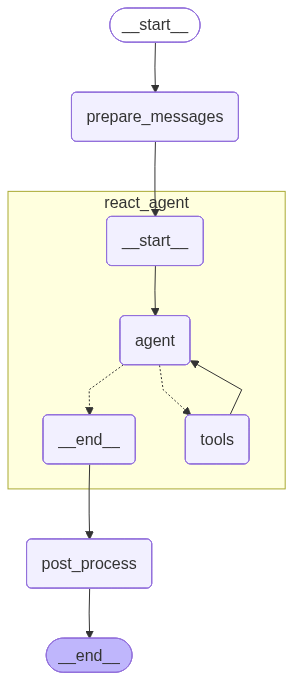

In [4]:
mlflow_agent = MLflowToolsAgent(llm)

mlflow_agent.show(xray=1)

### Run the Agent

Run the code to run the MLflow Agent and access the mlflow tools.

In [6]:
mlflow_agent.invoke_agent(
    user_instructions="What tools do you have access to?",
)

---MLFLOW TOOLS AGENT----
    * PREPARE MESSAGES
    * POST-PROCESS RESULTS


In [7]:
mlflow_agent.get_ai_message(markdown=True)

I have access to tools that allow me to interact with the MLflow platform for various purposes, such as managing experiments, runs, models, and artifacts. Here is a list of the available tools:

1. **mlflow_search_experiments**: Search and list existing MLflow experiments.
2. **mlflow_search_runs**: Search runs within one or more MLflow experiments.
3. **mlflow_create_experiment**: Create a new MLflow experiment by name.
4. **mlflow_predict_from_run_id**: Predict using an MLflow model directly from a given run ID.
5. **mlflow_launch_ui**: Launch the MLflow UI.
6. **mlflow_stop_ui**: Kill any process listening on the MLflow UI port.
7. **mlflow_list_artifacts**: List artifacts under a given MLflow run.
8. **mlflow_download_artifacts**: Download artifacts from MLflow to a local directory.
9. **mlflow_list_registered_models**: List all registered models in MLflow's model registry.
10. **mlflow_search_registered_models**: Search registered models in MLflow's registry using optional filters.
11. **mlflow_get_model_version_details**: Retrieve details about a specific model version in the MLflow registry.
12. **mlflow_get_run_details**: Retrieve run info, params, metrics, tags, and a shallow artifact listing.
13. **mlflow_transition_model_version_stage**: Transition a registered model version to a new stage (e.g., Staging, Production, Archived).
14. **mlflow_tracking_info**: Return current tracking URI, registry URI, and active run info (if any).
15. **mlflow_ui_status**: Check if a process is serving MLflow UI on a given port.

Let me know what you would like to do!

#### MLflow UI

Using the MLflow UI, you can view the models that were created by the H2OMLAgent.

In [ ]:
# Retrieve and display the leaderboard of models
mlflow_agent.invoke_agent(user_instructions="launch the mflow UI")

---MLFLOW TOOLS AGENT----
    * PREPARE MESSAGES
    * Tool: mlflow_launch_ui
    * POST-PROCESS RESULTS
    * Tool: mlflow_launch_ui


Backend store URI not provided. Using ./mlruns
Registry store URI not provided. Using backend store URI.


/Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/mlflow/server/handlers.py:259: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, artifact_uri)
/Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/mlflow/server/handlers.py:288: FutureWarning: The filesystem model registry backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri)
[MLflow] Security middleware enabl

INFO:     127.0.0.1:51591 - "GET / HTTP/1.1" 200 OK
INFO:     127.0.0.1:51591 - "GET /static-files/static/js/main.7ffba301.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:51593 - "GET /static-files/static/css/main.280d6c90.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:51593 - "GET /static-files/static/js/5759.45405231.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:51591 - "GET /static-files/static/js/3617.10568100.chunk.js HTTP/1.1" 200 OK
INFO:     127.0.0.1:51598 - "GET /static-files/static/css/762.26533251.chunk.css HTTP/1.1" 200 OK
INFO:     127.0.0.1:51599 - "GET /static-files/static/js/762.c86ecc42.chunk.js HTTP/1.1" 200 OK


/Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/mlflow/server/handlers.py:259: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, artifact_uri)


INFO:     127.0.0.1:51599 - "GET /ajax-api/2.0/mlflow/experiments/search?max_results=5&order_by=last_update_time+DESC HTTP/1.1" 200 OK
INFO:     127.0.0.1:51599 - "GET /static-files/static/media/fontawesome-webfont.20fd1704ea223900efa9.woff2 HTTP/1.1" 200 OK
INFO:     127.0.0.1:51599 - "GET /static-files/manifest.json HTTP/1.1" 200 OK
INFO:     127.0.0.1:51598 - "GET /static-files/favicon.ico HTTP/1.1" 200 OK


![AI Launched My MLflow UI](../img/ml_agents/mlflow_ui.jpg)

#### Generating Predictions From MLflow Models

The AI MLflow Agent will generate predictions from your logged Experiment Runs that contain models.

- Each experiment run typically contains a model that was trained.
- We can access the experiments and runs via the MLflow Agent.

In [9]:
# Get the H2O training function in markdown format
mlflow_agent.invoke_agent(user_instructions="What runs are available in the H2O AutoML experiment?")

---MLFLOW TOOLS AGENT----
    * PREPARE MESSAGES
    * Tool: mlflow_search_experiments


/Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/mlflow/tracking/_tracking_service/utils.py:177: FutureWarning: The filesystem tracking backend (e.g., './mlruns') will be deprecated in February 2026. Consider transitioning to a database backend (e.g., 'sqlite:///mlflow.db') to take advantage of the latest MLflow features. See https://github.com/mlflow/mlflow/issues/18534 for more details and migration guidance.
  return FileStore(store_uri, store_uri)


    * Tool: mlflow_search_runs
    * POST-PROCESS RESULTS
    * Tool: mlflow_search_experiments
    * Tool: mlflow_search_runs


In [10]:
mlflow_agent.get_ai_message(markdown=True)

Here are the runs available in the "H2O AutoML" experiment:

| Run ID                               | Run Name               | Status   | Start Time                 | End Time                   | Mean Per Class Error | AUCPR          | MSE             | Log Loss        | AUC             | RMSE            |
|--------------------------------------|-----------------------|----------|----------------------------|----------------------------|----------------------|----------------|-----------------|-----------------|------------------|------------------|
| 26d9f6326b104a3c9e8e2a41ca5c4e96    | upset-worm-867        | FAILED   | 2025-02-21 21:42:46       | 2025-02-21 21:43:20       | 0.2313               | 0.6680         | 0.1331          | 0.8502          | 0.3649           |
| 5a0d26ef3e9747d2b1908b39c5bc9a93    | victorious-swan-308   | FAILED   | 2025-02-21 21:42:00       | 2025-02-21 21:42:35       | 0.2313               | 0.6680         | 0.1331          | 0.8502          | 0.3649           |
| b3f7e4feae164383bbc7867d1afb449e    | salty-boar-852        | FAILED   | 2025-02-21 21:41:11       | 2025-02-21 21:41:44       | 0.2313               | 0.6680         | 0.1331          | 0.8502          | 0.3649           |
| ba9a378b232c4e138e90a5a140a08b99    | luxuriant-wolf-226    | FAILED   | 2025-02-21 21:40:15       | 2025-02-21 21:40:57       | 0.2351               | 0.6666         | 0.1332          | 0.8502          | 0.3650           |
| e070b829ebde401aa7704972cd87ae8a    | beautiful-goat-829     | FINISHED | 2025-01-22 22:16:20       | 2025-01-22 22:16:55       | 0.2341               | 0.6520         | 0.1355          | 0.8451          | 0.3681           |
| 39651085747949df980a85732bb861a2    | silent-swan-729       | FINISHED | 2025-01-22 22:09:52       | 2025-01-22 22:09:55       | 0.2297               | 0.6635         | 0.1340          | 0.8485          | 0.3660           |
| 79f8b65afc7348a0bd087e53574d6037    | ambitious-asp-675     | FINISHED | 2025-01-22 22:05:41       | 2025-01-22 22:05:44       | NaN                 | NaN            | NaN             | NaN             | NaN              |
| c0c91a68b55a4fb6a4da179e2dc7e183    | dazzling-ray-377      | FINISHED | 2025-01-22 21:51:39       | 2025-01-22 21:52:13       | 0.2338               | 0.6657         | 0.1335          | 0.8495          | 0.3653           |
| 961d9bc801b44f8da3328aee95baa06f    | intrigued-stag-405    | FINISHED | 2025-01-22 21:46:44       | 2025-01-22 21:47:19       | 0.2287               | 0.6665         | 0.1335          | 0.8495          | 0.3654           |
| 003d09c3bbcb4adbaf2a71f8a747a0e5    | handsome-shark-596    | FINISHED | 2025-01-22 21:37:01       | 2025-01-22 21:37:37       | 0.2301               | 0.6663         | 0.1334          | 0.8499          | 0.3652           |

- Runs 1 to 4 have failed, while the rest (5 to 10) are finished.
- Various metrics such as Mean Per Class Error, AUCPR, MSE, Log Loss, AUC, and RMSE are provided for each run.

In [11]:
mlflow_agent.invoke_agent(
    user_instructions="Make churn predictions on the data set provided using Run ID e070b829ebde401aa7704972cd87ae8a.",
    data_raw=df, # Provide the raw data to the agent for predictions
)

---MLFLOW TOOLS AGENT----
    * PREPARE MESSAGES
    * Tool: mlflow_predict_from_run_id


2025/12/09 15:52:04 WARNING mlflow.utils.requirements_utils: Detected one or more mismatches between the model's dependencies and the current Python environment:
 - mlflow (current: 3.7.0, required: mlflow==2.19.0)
 - cffi (current: 2.0.0, required: cffi==1.16.0)
 - jaraco-classes (current: uninstalled, required: jaraco-classes==3.4.0)
 - matplotlib (current: 3.10.6, required: matplotlib==3.8.0)
 - numpy (current: 2.2.5, required: numpy==1.26.4)
 - pandas (current: 2.3.3, required: pandas==2.2.2)
 - wcwidth (current: 0.2.13, required: wcwidth==0.2.5)
To fix the mismatches, call `mlflow.pyfunc.get_model_dependencies(model_uri)` to fetch the model's environment and install dependencies using the resulting environment file.


Checking whether there is an H2O instance running at http://localhost:54321..... not found.
Attempting to start a local H2O server...
  Java Version: java version "13.0.2" 2020-01-14; Java(TM) SE Runtime Environment (build 13.0.2+8); Java HotSpot(TM) 64-Bit Server VM (build 13.0.2+8, mixed mode, sharing)
  Starting server from /Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/h2o/backend/bin/h2o.jar
  Ice root: /var/folders/3s/bjq91lxs0jq9_zcw2q4l95gh0000gn/T/tmpwx66v4yd
  JVM stdout: /var/folders/3s/bjq91lxs0jq9_zcw2q4l95gh0000gn/T/tmpwx66v4yd/h2o_mdancho_started_from_python.out
  JVM stderr: /var/folders/3s/bjq91lxs0jq9_zcw2q4l95gh0000gn/T/tmpwx66v4yd/h2o_mdancho_started_from_python.err
  Server is running at http://127.0.0.1:54321
Connecting to H2O server at http://127.0.0.1:54321 ... successful.
Please download and install the latest version from: https://h2o-release.s3.amazonaws.com/h2o/latest_stable.html


H2O_cluster_uptime:,03 secs
H2O_cluster_timezone:,America/New_York
H2O_data_parsing_timezone:,UTC
H2O_cluster_version:,3.46.0.1
H2O_cluster_version_age:,"1 year, 8 months and 26 days"
H2O_cluster_name:,H2O_from_python_mdancho_lf52o1
H2O_cluster_total_nodes:,1
H2O_cluster_free_memory:,12 Gb
H2O_cluster_total_cores:,14
H2O_cluster_allowed_cores:,14
H2O_cluster_status:,"locked, healthy"


/Users/mdancho/opt/anaconda3/envs/ds4b_301p_dev_langchain_latest/lib/python3.10/site-packages/h2o/frame.py:1983: H2ODependencyWarning: Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using multi-thread, install datatable (for Python 3.9 or lower), or polars and pyarrow (for Python 3.10 or above) and activate it using:

with h2o.utils.threading.local_context(polars_enabled=True, datatable_enabled=True):
    pandas_df = h2o_df.as_data_frame()

  warnings.warn("Converting H2O frame to pandas dataframe using single-thread.  For faster conversion using"


    * POST-PROCESS RESULTS
    * Tool: mlflow_predict_from_run_id


In [12]:
mlflow_agent.get_ai_message(markdown=True)

Churn predictions have been made using the provided Run ID. Here are some sample predictions:

1. **Prediction**: Yes
   - Probability of No: 0.3664
   - Probability of Yes: 0.6336

2. **Prediction**: No
   - Probability of No: 0.9580
   - Probability of Yes: 0.0420

3. **Prediction**: No
   - Probability of No: 0.7057
   - Probability of Yes: 0.2943

4. **Prediction**: No
   - Probability of No: 0.9704
   - Probability of Yes: 0.0296

5. **Prediction**: Yes
   - Probability of No: 0.3054
   - Probability of Yes: 0.6946

If you need additional details or the complete predictions, please let me know!

In [16]:
pd.DataFrame(mlflow_agent.get_mlflow_artifacts()['mlflow_predict_from_run_id'])

,predict,No,Yes
0,Yes,0.366356,0.633644
1,No,0.957998,0.042002
2,No,0.705656,0.294344
3,No,0.970360,0.029640
4,Yes,0.305398,0.694602
...,...,...,...
7038,No,0.884750,0.115250
7039,No,0.861040,0.138960
7040,Yes,0.578824,0.421176
7041,Yes,0.299846,0.700154


In [5]:
mlflow_agent.invoke_agent("shut down the mflow UI")
mlflow_agent.get_ai_message(markdown=True)

---MLFLOW TOOLS AGENT----
    * PREPARE MESSAGES
    * Tool: mlflow_stop_ui
    * POST-PROCESS RESULTS
    * Tool: mlflow_stop_ui


I was unable to shut down the MLflow UI due to permission restrictions. You may need to run the command with elevated permissions or stop the MLflow UI manually. If you have access to the terminal, you can use the command `mlflow ui` to stop it, or identify the process running on the default port (5000) and terminate it.

# Want To Become A Full-Stack Generative AI Data Scientist?

![Generative AI Data Scientist](../../img/become_a_generative_ai_data_scientist.jpg)

I teach Generative AI Data Science to help you build AI-powered data science apps. [**Register for my next Generative AI for Data Scientists workshop here.**](https://learn.business-science.io/ai-register)